## Olist Data Analysis

In [35]:
import pandas as pd
import numpy as np
import os
import gc
import re
import pdb
import matplotlib.pyplot as plt
import japanize_matplotlib
from pandasql import sqldf
from matplotlib.pyplot import figure
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.font_manager as fm
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import optuna
from sklearn.metrics import confusion_matrix
from mpl_toolkits.basemap import Basemap

In [32]:
os.chdir('C:\my_working_env\deeplearning_practice\ey_presentation')
fprop = fm.FontProperties(fname='C:/my_working_env/deeplearning_practice/paytest/yayyay_data/japanese_font/static/NotoSansJP-Black.ttf')

Merge each datasets into one for analysis.

In [33]:
df_customer = pd.read_csv('./data/olist_customers_dataset.csv')
df_location = pd.read_csv('./data/olist_geolocation_dataset.csv')
df_item = pd.read_csv('./data/olist_order_items_dataset.csv')
df_payment = pd.read_csv('./data/olist_order_payments_dataset.csv')
df_review = pd.read_csv('./data/olist_order_reviews_dataset.csv')
df_order_status = pd.read_csv('./data/olist_orders_dataset.csv')
df_product = pd.read_csv('./data/olist_products_dataset.csv')
df_name = pd.read_csv('./data/product_category_name_translation.csv')
df_seller = pd.read_csv('./data/olist_sellers_dataset.csv')

df_customer['customer_zip_code_prefix'] = df_customer['customer_zip_code_prefix'].astype(str)
#df_location['geolocation_zip_code_prefix'] = df_location['geolocation_zip_code_prefix'].astype(str)
df_item['order_item_id'] = df_item['order_item_id'].astype(str)
df_review['review_score'] = df_review['review_score'].astype(int)
df_item['shipping_limit_date'] = pd.to_datetime( df_item.shipping_limit_date )
df_review['review_creation_date'] = pd.to_datetime( df_review.review_creation_date )
df_review['review_answer_timestamp'] = pd.to_datetime( df_review.review_answer_timestamp )
df_order_status['order_purchase_timestamp'] = pd.to_datetime( df_order_status.order_purchase_timestamp )
df_order_status['order_approved_at'] = pd.to_datetime( df_order_status.order_approved_at )
df_order_status['order_delivered_carrier_date'] = pd.to_datetime( df_order_status.order_delivered_carrier_date )
df_order_status['order_delivered_customer_date'] = pd.to_datetime( df_order_status.order_delivered_customer_date )
df_order_status['order_estimated_delivery_date'] = pd.to_datetime( df_order_status.order_estimated_delivery_date )

df_customer.drop( columns=['customer_zip_code_prefix'], axis=1, inplace=True )
df_location.drop( columns=['geolocation_zip_code_prefix'], axis=1, inplace=True )
df_item.drop( columns=['order_item_id', 'shipping_limit_date'], axis=1, inplace=True )
df_payment.drop( columns=['payment_sequential'], axis=1, inplace=True )
df_review.drop( columns=['review_creation_date','review_answer_timestamp'], axis=1, inplace=True )
df_order_status.drop( columns=['order_approved_at'], axis=1, inplace=True )
df_product.drop( columns=['product_name_lenght','product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm' ], axis=1, inplace=True )
df_seller.drop( columns=['seller_zip_code_prefix','seller_state'], axis=1, inplace=True ) 
gc.collect()

#df_location = df_location.rename( columns={'geolocation_state': 'customer_state'} )
df_payment = pd.merge(df_payment, df_item, on='order_id', how='left')
df_payment = pd.merge(df_payment, df_review, on='order_id', how='left')
df_payment = pd.merge(df_payment, df_order_status, on='order_id', how='left')
df_payment = pd.merge(df_payment, df_customer, on='customer_id', how='left')
df_payment = pd.merge(df_payment, df_product , on='product_id', how='left')
df_payment = pd.merge(df_payment, df_name , on='product_category_name', how='left')
df_payment = pd.merge(df_payment, df_seller , on='seller_id', how='left')
df_payment.drop( columns=['product_category_name'], axis=1, inplace=True )
df_payment.drop( columns=['review_id'], axis=1, inplace=True )
gc.collect()

df_payment['deliver_days'] = (df_payment['order_delivered_customer_date'] - df_payment['order_purchase_timestamp']).dt.days
df_payment['expected_deliver_diff'] = (df_payment['order_estimated_delivery_date'] - df_payment['order_delivered_customer_date']).dt.days
df_payment['order_shipped_days'] = (df_payment['order_delivered_carrier_date'] - df_payment['order_purchase_timestamp']).dt.days
df_payment['shipping_days'] = df_payment['deliver_days'] - df_payment['order_shipped_days']

df_payment.dropna(subset=['order_delivered_customer_date'], inplace=True )
df_payment.sort_values('order_delivered_customer_date', inplace=True)
df_payment.drop_duplicates(subset =['order_id','order_purchase_timestamp'], keep="first", ignore_index=True, inplace=True)

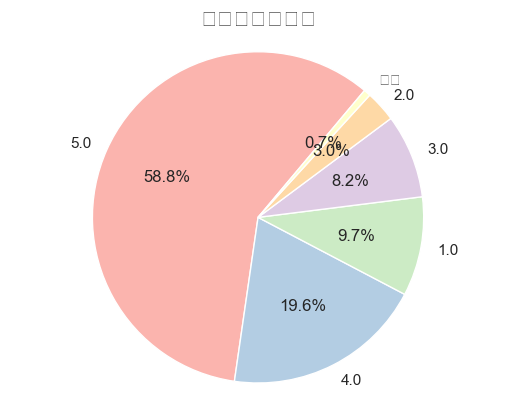

In [34]:
df_payment['review_score_str'] = df_payment["review_score"].fillna( value="空白" ) 
value_counts = df_payment["review_score_str"].value_counts(dropna=False)
colors = ['#FBB4AE', '#B3CDE3', '#CCEBC5', '#DECBE4', '#FED9A6', '#FFFFCC']
plt.pie( value_counts, labels=value_counts.index.tolist(), autopct='%1.1f%%', colors=colors, startangle=50)
plt.axis('equal')
plt.title("レビュースコア", fontsize=16)
plt.show()
plt.close()

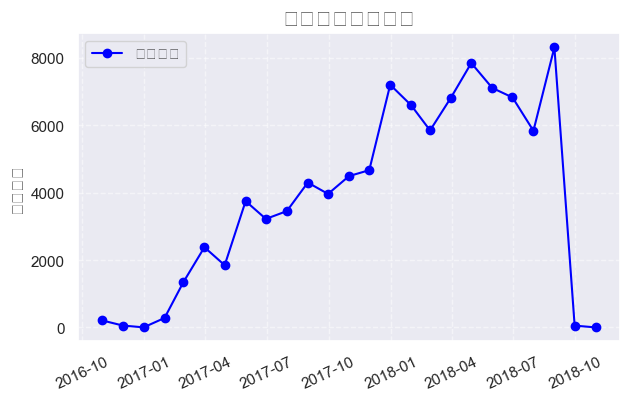

In [30]:
monthly_payment = df_payment.groupby( pd.Grouper(key='order_delivered_customer_date', freq='M') )['payment_value'].count()
figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.plot(monthly_payment.index, monthly_payment.values, color='blue', linestyle='-', marker='o')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['取引回数'], loc='upper left', )
#plt.xlabel('Year-Month')
plt.ylabel('取引回数', )
plt.title('取引回数（月次）', fontsize=16, )
plt.xticks(rotation=25)
plt.show()
plt.close()


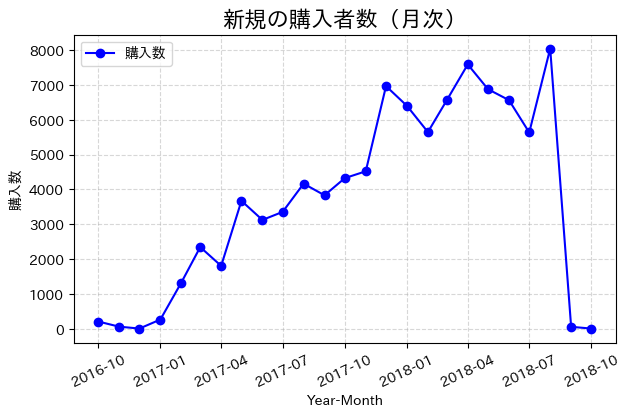

In [6]:
unique_customers = set()
new_customer_counts = []

for index, row in df_payment.iterrows():
    customer_id = row['customer_unique_id']
    order_date = row['order_delivered_customer_date']
    
    # Check if customer_id appeared in previous months
    if customer_id not in unique_customers:
        # Add customer_id to the set
        unique_customers.add(customer_id)
        
        # Count the number of new customer_ids for each month
        new_customer_counts.append((order_date.year, order_date.month, len(unique_customers)))

df_new_customers = pd.DataFrame(new_customer_counts, columns=['Year', 'Month', 'new_customer_count'])

df_new_customers['year_month'] = df_new_customers.apply( lambda x: str(x.Year) + '-' +  str(x.Month) , axis=1 )
df_new_customers = df_new_customers.groupby(['year_month']).count()

df_new_customers.index = pd.to_datetime(df_new_customers.index)
df_new_customers = df_new_customers.sort_index()

figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.plot( df_new_customers.index, df_new_customers.new_customer_count, color='blue', linestyle='-', marker='o' ) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['購入数'], loc='upper left')
#plt.xlabel('Year-Month')
plt.ylabel('購入数')
plt.title('新規の購入者数（月次）', fontsize=16 )
plt.xticks(rotation=25)
plt.show()
plt.close()

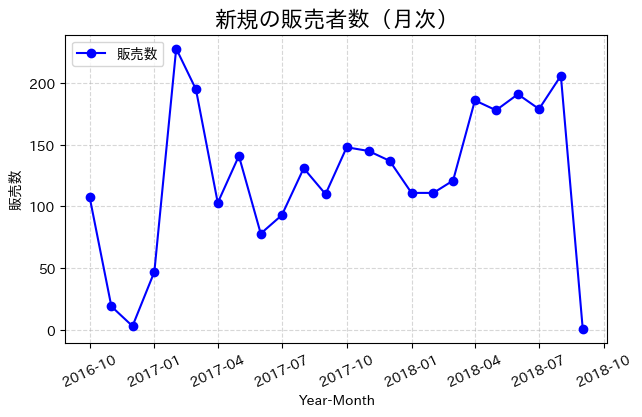

In [7]:
unique_customers = set()
new_customer_counts = []

for index, row in df_payment.iterrows():
    customer_id = row['seller_id']
    order_date = row['order_delivered_customer_date']
    
    # Check if customer_id appeared in previous months
    if customer_id not in unique_customers:
        # Add customer_id to the set
        unique_customers.add(customer_id)
        
        # Count the number of new customer_ids for each month
        new_customer_counts.append((order_date.year, order_date.month, len(unique_customers)))

df_new_customers = pd.DataFrame(new_customer_counts, columns=['Year', 'Month', 'new_customer_count'])

df_new_customers['year_month'] = df_new_customers.apply( lambda x: str(x.Year) + '-' +  str(x.Month) , axis=1 )
df_new_customers = df_new_customers.groupby(['year_month']).count()

df_new_customers.index = pd.to_datetime(df_new_customers.index)
df_new_customers = df_new_customers.sort_index()

figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.plot( df_new_customers.index, df_new_customers.new_customer_count, color='blue', linestyle='-', marker='o' ) 
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(['販売数'], loc='upper left')
plt.xlabel('Year-Month')
plt.ylabel('販売数')
plt.title('新規の販売者数（月次）', fontsize=16 )
plt.xticks(rotation=25)
plt.show()
plt.close()

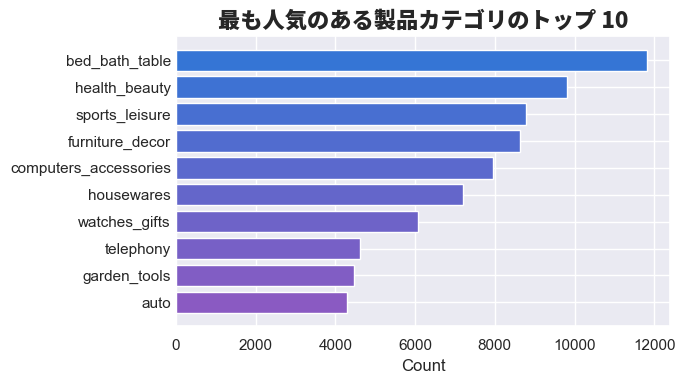

In [8]:
def hex_to_RGB(hex_str):
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]

category_counts = df_payment['product_category_name_english'].value_counts().head(10).sort_values(ascending=True)

sns.set_theme(style='darkgrid')

figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.barh( category_counts.index, category_counts.values, color=get_color_gradient("#8A5AC2", "#3575D5", len(category_counts)) )
plt.xlabel('Count')
#plt.xticks( fontproperties=fprop, )
#plt.ylabel('Product Category')
plt.tick_params(axis='y', length=0)
plt.title('最も人気のある製品カテゴリのトップ 10', fontproperties=fprop, fontsize=16 )
plt.tight_layout()
plt.savefig('top10_category_count.png' ,  dpi=200 )
plt.show()
plt.close()

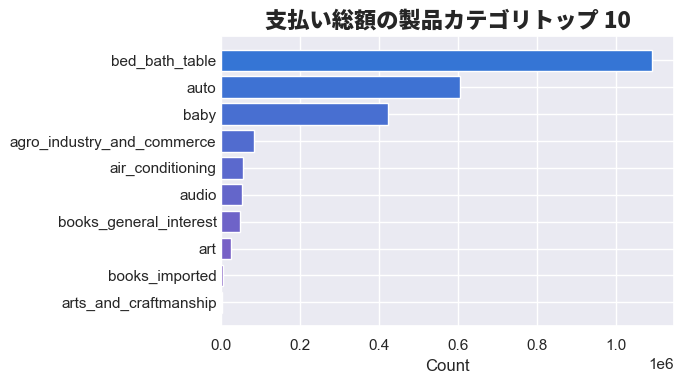

In [9]:
category_price = df_payment.groupby(['product_category_name_english'])['price'].sum().head(10).sort_values( ascending=True )

figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.barh( category_price.index, category_price.values, color=get_color_gradient("#8A5AC2", "#3575D5", len(category_price)) )
plt.xlabel('Count')
#plt.xticks( fontproperties=fprop, )
#plt.ylabel('Product Category')
plt.tick_params(axis='y', length=0)
plt.title('支払い総額の製品カテゴリトップ 10', fontproperties=fprop, fontsize=16 )
plt.tight_layout()
plt.show()
plt.close()

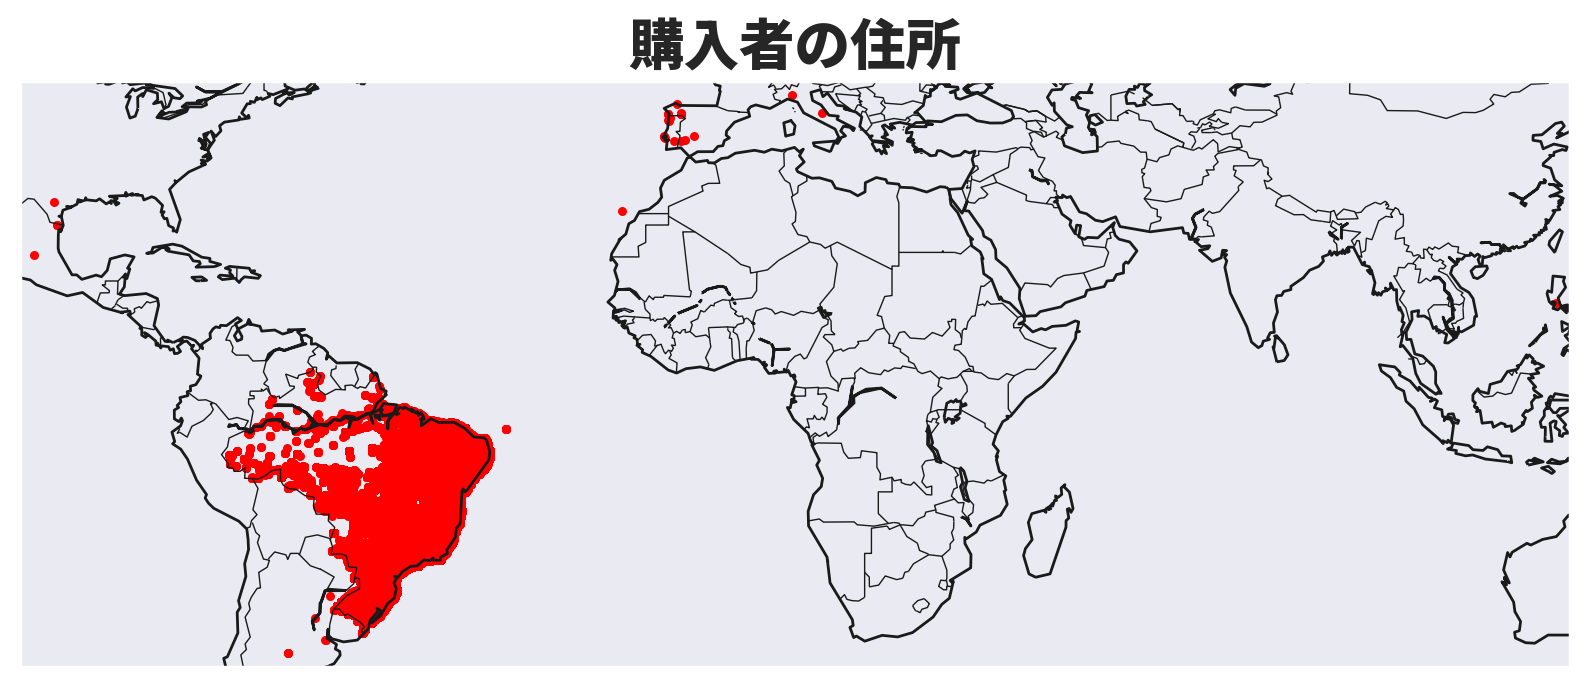

In [10]:
latitude = df_location.geolocation_lat
longitude = df_location.geolocation_lng

figure(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k') 
plt.scatter(longitude, latitude, marker='o', color='red', s=5)

m = Basemap(llcrnrlon=min(longitude)-2, llcrnrlat=min(latitude)-2,
            urcrnrlon=max(longitude)+2, urcrnrlat=max(latitude)+2, )
            # resolution='l', projection='merc', lat_0=np.mean(latitude), lon_0=np.mean(longitude))

m.drawcoastlines()
m.drawcountries()

plt.xlim(min(longitude)-2, max(longitude)+2)
plt.ylim(min(latitude)-2, max(latitude)+2)
plt.title('購入者の住所', fontproperties=fprop, fontsize=20 )
plt.show()
plt.close()  

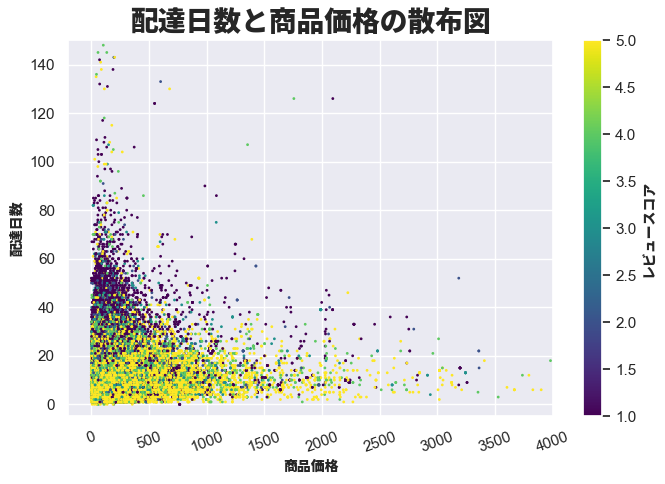

In [11]:
figure(num=None, figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k') 
plt.scatter( df_payment['payment_value'], df_payment['deliver_days'],
            c=df_payment['review_score'], cmap='viridis', s=1 )

plt.xlabel('商品価格', fontproperties=fprop,)
plt.ylabel('配達日数', fontproperties=fprop,)
plt.xlim([ -200, 4000])
plt.ylim([ -5, 150])
plt.title('配達日数と商品価格の散布図', fontproperties=fprop, fontsize=20 )
plt.xticks(rotation=20)
cbar = plt.colorbar()
cbar.set_label('レビュースコア', fontproperties=fprop,)
plt.tight_layout()
plt.savefig('delivertime_review_scatter.png' ,  dpi=200 )
plt.show()
plt.close()

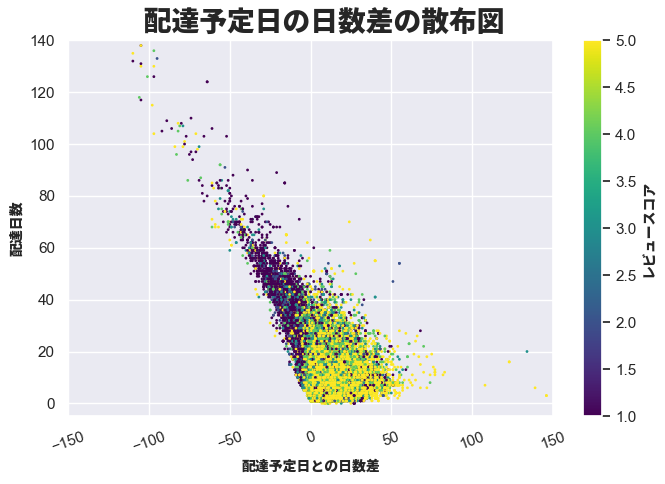

In [12]:
figure(num=None, figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k') 
plt.scatter( df_payment['expected_deliver_diff'], df_payment['deliver_days'],
            c=df_payment['review_score'], cmap='viridis', s=1 )

plt.xlabel('配達予定日との日数差', fontproperties=fprop,)
plt.ylabel('配達日数', fontproperties=fprop,)
plt.xlim([ -150, 150 ])
plt.ylim([ -5, 140])
plt.title('　配達予定日の日数差の散布図', fontproperties=fprop, fontsize=20 )
plt.xticks(rotation=20)
cbar = plt.colorbar()
cbar.set_label('レビュースコア', fontproperties=fprop,)
plt.tight_layout()
plt.show()
plt.close() 

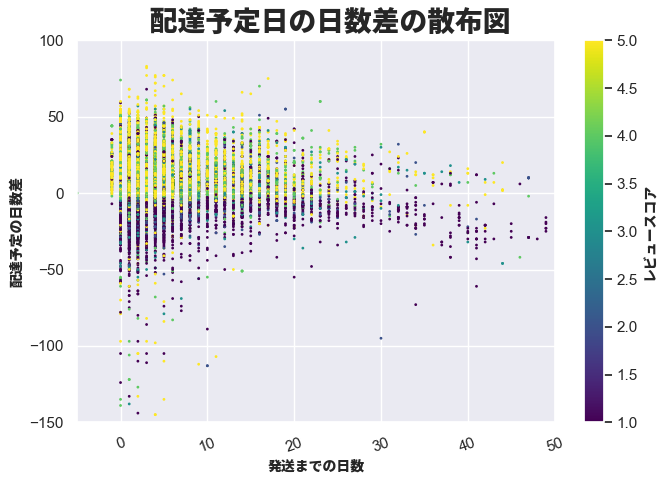

In [13]:
figure(num=None, figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k') 
plt.scatter( df_payment['order_shipped_days'], df_payment['expected_deliver_diff'],
            c=df_payment['review_score'], cmap='viridis', s=1 )

plt.xlabel('発送までの日数', fontproperties=fprop,)
plt.ylabel('配達予定の日数差', fontproperties=fprop,)
plt.xlim([ -5, 50 ])
plt.ylim([ -150, 100])
plt.title('　配達予定日の日数差の散布図', fontproperties=fprop, fontsize=20 )
plt.xticks(rotation=20)
cbar = plt.colorbar()
cbar.set_label('レビュースコア', fontproperties=fprop,)
plt.tight_layout()
plt.show()
plt.close() 

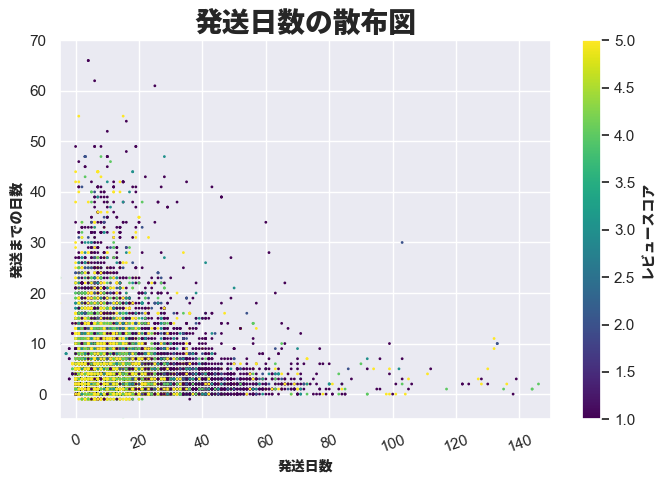

In [14]:
figure(num=None, figsize=(7, 5), dpi=100, facecolor='w', edgecolor='k') 
plt.scatter( df_payment['shipping_days'], df_payment['order_shipped_days'],
            c=df_payment['review_score'], cmap='viridis', s=1 )

plt.xlabel('発送日数', fontproperties=fprop,)
plt.ylabel('発送までの日数', fontproperties=fprop,)
plt.xlim([ -5, 150 ])
plt.ylim([ -5, 70])
plt.title('発送日数の散布図', fontproperties=fprop, fontsize=20 )
plt.xticks(rotation=20)
cbar = plt.colorbar()
cbar.set_label('レビュースコア', fontproperties=fprop,)
plt.tight_layout()
plt.show()
plt.close() 


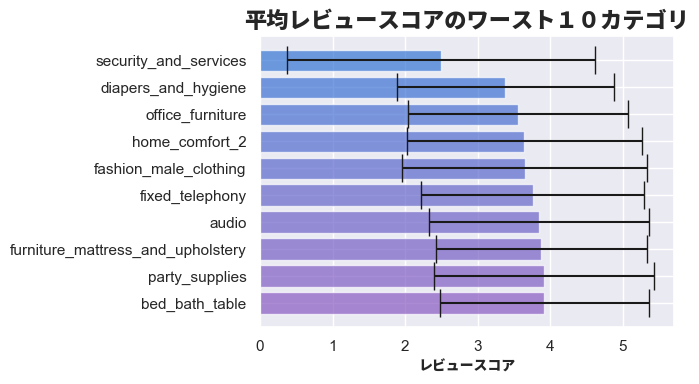

In [15]:
grouped = df_payment.groupby('product_category_name_english')['review_score'].agg(['mean', 'std'])
worst_10 = grouped.sort_values('mean', ascending=False).tail(10)

figure(num=None, figsize=(7, 4), dpi=100, facecolor='w', edgecolor='k') 
plt.barh(worst_10.index, worst_10['mean'], xerr=worst_10['std'], alpha=0.7, capsize=10, color=get_color_gradient("#8A5AC2", "#3575D5", len(worst_10)))
#plt.ylabel('Product Category')
plt.xlabel('レビュースコア', fontproperties=fprop,)
plt.title('平均レビュースコアのワースト１０カテゴリ', fontproperties=fprop, fontsize=16)
plt.tight_layout()
plt.savefig('worst10_review.png' ,  dpi=200 )
plt.show()
plt.close() 

Prepare the data for traing.

In [16]:
df = df_payment.drop( columns=['order_id', 'payment_type', 'payment_installments', 
                            'payment_value', 'freight_value', 'review_score',
                            'customer_id', 'order_status', 'order_purchase_timestamp',
                            'order_delivered_carrier_date', 'order_delivered_customer_date',
                            'order_estimated_delivery_date', 'customer_state', 'review_score_str',
                            'deliver_days', 'expected_deliver_diff', 
                            ], axis=1 ).copy()
df.reset_index(drop=True, inplace=True)

positive_words = ["excelente", "maravilloso", "genial", "recomendado", "satisfecho", "contento", "bom", "otimo", 
                    "genial", "perfeito", "satisfeito", "satisfeita", "boa", "genial", "encantado", "feliz",
                    "buen", "maravilloso", ]

# Here, if the review comments/title contain positive words, it is labeled as satisfied=1.
def is_satisfied(title, comment):
    if title is not np.nan:
        for word in positive_words:
            if re.search(word, title.lower()):
                return 1
    elif comment is not np.nan:
        for word in positive_words:
            if re.search(word, comment.lower()):
                return 1
    return 0

df['satisfied'] = df.apply( lambda x: is_satisfied(x.review_comment_title, x.review_comment_message) , axis=1 )

df.drop( columns=['review_comment_title','review_comment_message'], axis=1, inplace=True )
df['price'] = df['price'].round(decimals=-2)

X = df.drop(['satisfied'], axis=1)
y = df['satisfied']

categorical_cols = ['product_id', 'seller_id',  'customer_unique_id', 'product_category_name_english', 'customer_city', 'seller_city']
for col in categorical_cols:
    X[col] = X[col].astype('category')

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [26]:
def feval(preds, train_data):
    labels = train_data.get_label()
    preds_rounded = [1 if x >= 0.5 else 0 for x in preds]
    f1 = f1_score(labels, preds_rounded)
    return 'f1', f1, True   # metric_name, metric_value, is_higher_better
    
def objective(trial):
    params = {
            'objective': 'binary',
            'metric': 'binary_logloss',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'num_leaves': trial.suggest_int('num_leaves', 10, 200),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
            'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
            'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
            'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
            'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
            'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    model = lgb.train(
                        params,
                        lgb_train,
                        valid_sets=[lgb_train, lgb_val],
                        verbose_eval=False,
                        num_boost_round=1000,
                        early_stopping_rounds=10,
                        feval=feval,
                    )
                        
    y_pred = model.predict(X_val)
    y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

    val = f1_score(y_val, y_pred)
    #val = precision_score(y_val, y_pred)
    #val = recall_score(y_val, y_pred)
    return val

import warnings
warnings.filterwarnings("ignore")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-07-17 12:11:36,887] A new study created in memory with name: no-name-d0db9efb-fe07-42a9-bc63-3d93aab41a94
[I 2023-07-17 12:11:39,105] Trial 0 finished with value: 0.012937230474365118 and parameters: {'num_leaves': 120, 'learning_rate': 0.054910281711073976, 'feature_fraction': 0.8832038441652847, 'bagging_fraction': 0.4766133120785767, 'bagging_freq': 8, 'min_child_samples': 39, 'lambda_l1': 6.0063926719728165e-06, 'lambda_l2': 0.0013270721025816184}. Best is trial 0 with value: 0.012937230474365118.
[I 2023-07-17 12:11:41,567] Trial 1 finished with value: 0.006229036895064686 and parameters: {'num_leaves': 114, 'learning_rate': 0.03241745839990518, 'feature_fraction': 0.9761189359541, 'bagging_fraction': 0.5636377945711931, 'bagging_freq': 9, 'min_child_samples': 41, 'lambda_l1': 0.00039280569454192606, 'lambda_l2': 1.9837088274869639}. Best is trial 0 with value: 0.012937230474365118.
[I 2023-07-17 12:11:44,070] Trial 2 finished with value: 0.005270723526593196 and parameter

[I 2023-07-17 12:12:38,248] Trial 21 finished with value: 0.05701964542405367 and parameters: {'num_leaves': 137, 'learning_rate': 0.096812738750337, 'feature_fraction': 0.8325797566599146, 'bagging_fraction': 0.9857696149321307, 'bagging_freq': 8, 'min_child_samples': 29, 'lambda_l1': 4.4942894721064954e-08, 'lambda_l2': 1.2543883774414267e-08}. Best is trial 15 with value: 0.0689985625299473.
[I 2023-07-17 12:12:41,941] Trial 22 finished with value: 0.05701964542405367 and parameters: {'num_leaves': 162, 'learning_rate': 0.08034546818602388, 'feature_fraction': 0.8888676079808269, 'bagging_fraction': 0.9955838388117684, 'bagging_freq': 9, 'min_child_samples': 40, 'lambda_l1': 1.277652513483493e-08, 'lambda_l2': 7.765266579034478e-08}. Best is trial 15 with value: 0.0689985625299473.
[I 2023-07-17 12:12:45,008] Trial 23 finished with value: 0.055103018687110684 and parameters: {'num_leaves': 150, 'learning_rate': 0.0996301634230161, 'feature_fraction': 0.709244256303808, 'bagging_frac

[I 2023-07-17 12:13:48,765] Trial 42 finished with value: 0.056061332055582176 and parameters: {'num_leaves': 178, 'learning_rate': 0.07670579921973329, 'feature_fraction': 0.7840994698549334, 'bagging_fraction': 0.9249606896284607, 'bagging_freq': 10, 'min_child_samples': 8, 'lambda_l1': 2.971040793529411e-08, 'lambda_l2': 6.488211818941948e-06}. Best is trial 34 with value: 0.07666506947771921.
[I 2023-07-17 12:13:52,140] Trial 43 finished with value: 0.06564446574029707 and parameters: {'num_leaves': 200, 'learning_rate': 0.08855994738374437, 'feature_fraction': 0.8393404919296705, 'bagging_fraction': 0.8468907158012273, 'bagging_freq': 9, 'min_child_samples': 11, 'lambda_l1': 2.403564762935589e-08, 'lambda_l2': 9.566882211801843e-07}. Best is trial 34 with value: 0.07666506947771921.
[I 2023-07-17 12:13:55,593] Trial 44 finished with value: 0.06851940584571155 and parameters: {'num_leaves': 200, 'learning_rate': 0.09881274415815963, 'feature_fraction': 0.8156008847653696, 'bagging_

[I 2023-07-17 12:14:59,073] Trial 63 finished with value: 0.06085289889793963 and parameters: {'num_leaves': 181, 'learning_rate': 0.08329710905172814, 'feature_fraction': 0.8594162822476803, 'bagging_fraction': 0.9344910532385169, 'bagging_freq': 6, 'min_child_samples': 7, 'lambda_l1': 2.2334296860031738e-08, 'lambda_l2': 2.4679929048789964e-07}. Best is trial 34 with value: 0.07666506947771921.
[I 2023-07-17 12:15:02,800] Trial 64 finished with value: 0.059894585529468136 and parameters: {'num_leaves': 174, 'learning_rate': 0.07958442144972777, 'feature_fraction': 0.8435889704913718, 'bagging_fraction': 0.9138363074584676, 'bagging_freq': 8, 'min_child_samples': 3, 'lambda_l1': 5.639807957619843e-07, 'lambda_l2': 1.0884707415449554e-07}. Best is trial 34 with value: 0.07666506947771921.
[I 2023-07-17 12:15:06,190] Trial 65 finished with value: 0.05797795879252515 and parameters: {'num_leaves': 187, 'learning_rate': 0.08646301832611307, 'feature_fraction': 0.8821476618724469, 'bagging

[I 2023-07-17 12:16:15,185] Trial 84 finished with value: 0.07570675610924772 and parameters: {'num_leaves': 182, 'learning_rate': 0.0937958240668174, 'feature_fraction': 0.9701247757010946, 'bagging_fraction': 0.9474812485563164, 'bagging_freq': 8, 'min_child_samples': 28, 'lambda_l1': 1.8884887822405383e-07, 'lambda_l2': 0.00015065194166801973}. Best is trial 82 with value: 0.0828941063727839.
[I 2023-07-17 12:16:19,109] Trial 85 finished with value: 0.07522759942501198 and parameters: {'num_leaves': 181, 'learning_rate': 0.0859114505961795, 'feature_fraction': 0.9662546679618316, 'bagging_fraction': 0.9642107983898432, 'bagging_freq': 8, 'min_child_samples': 29, 'lambda_l1': 2.2880047214734768e-07, 'lambda_l2': 0.0001336478673733048}. Best is trial 82 with value: 0.0828941063727839.
[I 2023-07-17 12:16:22,900] Trial 86 finished with value: 0.06420699568758984 and parameters: {'num_leaves': 150, 'learning_rate': 0.08566280486726328, 'feature_fraction': 0.9711050701198864, 'bagging_fr

Best trial:
  Value: 0.08337326305701964
  Params: 
    num_leaves: 175
    learning_rate: 0.09231768269576017
    feature_fraction: 0.9571007065749711
    bagging_fraction: 0.9885681780230422
    bagging_freq: 8
    min_child_samples: 34
    lambda_l1: 1.151076921843455e-06
    lambda_l2: 0.0007083305766877359
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15201
[LightGBM] [Info] Number of data points in the train set: 92575, number of used features: 9
[LightGBM] [Info] Start training from score 0.109587
F-score on test set: 0.08003078106964216


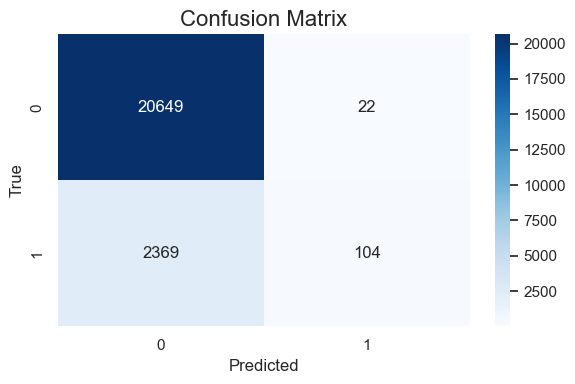

In [27]:
print('Best trial:')
trial = study.best_trial
print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

best_params = trial.params
lgb_train_val = lgb.Dataset(X_train_val, y_train_val)
model = lgb.train(best_params, lgb_train_val)

y_pred = model.predict(X_test)
y_pred = [1 if x >= 0.5 else 0 for x in y_pred]

f_score = f1_score(y_test, y_pred)
print("F-score on test set:", f_score)

cm = confusion_matrix(y_test, y_pred)
labels = np.unique(y_test)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()
plt.close()